# Data loading

In [2]:
!pip install -q fastplot

In [3]:
import pandas as pd
import os
import gzip
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import fastplot
%matplotlib inline
from datetime import timedelta, datetime
import json
import requests
from bs4 import BeautifulSoup
from scipy.stats import spearmanr

In [4]:
# Read or create dfs for each year and a cumulative one
path_csv_folder = './data'
path_complete_csv = os.path.join(path_csv_folder, 'dataset.csv')
if not os.path.exists(path_complete_csv):
    if not os.path.exists(path_csv_folder):
        os.mkdir(path_csv_folder)
    path_epss_folder = '/share/smartdata/security/phishing/epss'
    path_years_folders = [os.path.join(path_epss_folder, name) for name in os.listdir(path_epss_folder) if os.path.isdir(os.path.join(path_epss_folder, name))]
    print('Starting reading from filesystem...')
    year_df = []
    for year_path in path_years_folders:
        year = year_path.split('/')[-1]
        print(f"Year {year}")
        months_folders = [os.path.join(year_path, name) for name in os.listdir(year_path) if os.path.isdir(os.path.join(year_path, name))]
        month_dfs = []
        for month_folder in months_folders:
            for file in os.listdir(month_folder):
                path = os.path.join(month_folder, file)
                if os.path.isfile(path) and file.endswith('.csv.gz'):
                    with gzip.open(path, 'rt') as file_gz:
                        df_temp = pd.read_csv(file_gz, comment='#')
                        df_temp['date'] = file.replace('.csv.gz', '')
                        month_dfs.append(df_temp)
        year_df.append(pd.concat(month_dfs, ignore_index=True))
    df_dataset = pd.concat(year_df, ignore_index=True)
    df_dataset['date'] = pd.to_datetime(df_dataset['date'])
    df_dataset = df_dataset.sort_values(by=['date'])
    df_dataset.to_csv(path_complete_csv, index=False)
    print('Dataset saved')
else:
    print('Complete CSV detected, reading...')
    with open(path_complete_csv, 'r') as file_csv:
        df_dataset = pd.read_csv(file_csv)
    df_dataset['date'] = pd.to_datetime(df_dataset['date'])
    print('Dataset loaded')

Complete CSV detected, reading...
Dataset loaded


In [6]:
# df with CVEs with EPSS > T at least one time
path_highest_epss_csv = os.path.join(path_csv_folder, 'highest_epss.csv')
THRESHOLD = 0.7
if not os.path.exists(path_highest_epss_csv):
    max_epss = df_dataset.groupby('cve')['epss'].max()
    good_cve = max_epss[max_epss > THRESHOLD]
    unique_cve = set(good_cve.index.values)
    df_highest_epss = df_dataset[df_dataset['cve'].isin(unique_cve)]
    df_highest_epss.to_csv(path_highest_epss_csv, index=False)
else:
    with open(path_highest_epss_csv, 'r') as file_csv:
        df_highest_epss = pd.read_csv(file_csv)
    df_highest_epss['date'] = pd.to_datetime(df_highest_epss['date'])
df_highest_epss_2223 = df_highest_epss[df_highest_epss['cve'].str.contains('CVE-2022|CVE-2023')]
print('df of highest EPSS ready')

df of highest EPSS ready


In [7]:
# Read unique CVEs from Google Project Zero spreadsheet
document_id = '1lkNJ0uQwbeC1ZTRrxdtuPLCIl7mlUreoKfSIgajnSyY'
tab_name = 'All'
url = f"https://docs.google.com/spreadsheets/d/{document_id}/gviz/tq?tqx=out:csv&sheet={tab_name}"
df_pz_sheet = pd.read_csv(url)
cve_pz = set(df_pz_sheet['CVE'].dropna().apply(lambda r: r if 'CVE' in r else None).dropna())

In [8]:
# df with CVEs from Google Project Zero
path_pz_csv = os.path.join(path_csv_folder, 'project_zero.csv')
if not os.path.exists(path_pz_csv):
    df_pz = df_dataset[df_dataset['cve'].isin(cve_pz)]
    df_pz.to_csv(path_pz_csv, index=False)
else:
    with open(path_pz_csv, 'r') as file_csv:
        df_pz = pd.read_csv(file_csv)
    df_pz['date'] = pd.to_datetime(df_pz['date'])
print('df of CVEs from Google Project Zero ready')

df of CVEs from Google Project Zero ready


In [9]:
# Read unique CVEs from CISA KEV json
path_kev_catalog = './data/kev_30-01-24/cisa_kev.json'
with open(path_kev_catalog, 'r') as file_json:
    data = json.load(file_json)
cve_kev = []
dict_cve_kev = []
for e in data['vulnerabilities']:
    dict_cve_kev.append(e)
    cve_kev.append(e['cveID'])
df_kev_sheet = pd.DataFrame.from_dict(dict_cve_kev)

In [10]:
# df with the CVEs of CISA KEV
path_kev_csv = os.path.join(path_csv_folder, 'cisa_kev.csv')
if not os.path.exists(path_kev_csv):
    df_kev = df_dataset[df_dataset['cve'].isin(cve_kev)]
    df_kev.to_csv(path_kev_csv, index=False)
else:
    with open(path_kev_csv, 'r') as file_csv:
        df_kev = pd.read_csv(file_csv)
    df_kev['date'] = pd.to_datetime(df_kev['date'])
print('df of CVEs from CISA KEV ready')

df of CVEs from CISA KEV ready


# Analyses

## Cardinality

In [99]:
# Missing dates
dates = df_dataset['date'].unique()
dates_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
missing_dates = dates_range.difference(dates)
print('Missing dates:')
for e in missing_dates:
    print(str(e).split(' ')[0])

Missing dates:
2021-04-22
2021-04-23
2021-04-24
2021-04-25
2021-04-26
2021-06-07
2021-06-18
2022-07-14


In [126]:
# CVEs disappearing from the dataset
base_path = './missing'
step = timedelta(days=1)
date_from = df_dataset['date'].iloc[0]
date_to = df_dataset['date'].iloc[-1]
previous_day_cve = set(df_dataset.loc[df_dataset['date'] == date_from, 'cve'].unique())
dates = df_dataset['date'].unique()
while date_from <= date_to:
    date_from += step
    if date_from not in dates:
        continue
    print(date_from)
    date = str(date_from).split(' ')[0].split('-')
    year = date[0]
    month = date[1]
    day = date[2]
    path = os.path.join(base_path, year, month)
    if not os.path.exists(path):
        os.makedirs(path)
    day_path = os.path.join(path, f"{'-'.join(date)}.txt")
    if not os.path.exists(day_path):
        current_day_cve = set(df_dataset.loc[df_dataset['date'] == date_from, 'cve'].unique())
        if not previous_day_cve.issubset(current_day_cve):
            differing_cves = previous_day_cve - current_day_cve
            with open(day_path, 'w') as file:
                for e in sorted(differing_cves):
                    file.write(f"{e}\n")
        previous_day_cve = previous_day_cve.union(current_day_cve)
    else:
        with open(day_path, 'r') as file:
            for line in file:
                previous_day_cve.add(line.strip())
    clear_output(wait=True)
print(f"Check {path} to read the CVEs that disappered")

Check ./missing/2024/01 to read the CVEs that disappered


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

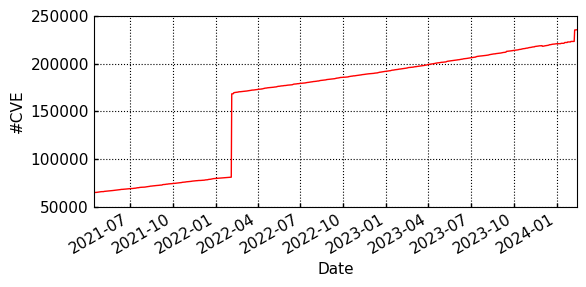

In [12]:
# Number of different CVEs from the start to today
data = df_dataset.groupby('date').size()
fastplot.plot((data.index, data.values), None, grid=True, xlabel='Date', ylabel='#CVE', xticks_rotate=30, figsize=(6, 3))

In [11]:
# Number of unique CVEs for each dataframe
print("Number of unique CVEs for each dataframe")
print(f"Complete: {len(df_dataset.groupby('cve'))}")
print(f"Highest: {len(df_highest_epss.groupby('cve'))}")
print(f"CISA KEV: {len(df_kev.groupby('cve'))}")
print(f"Project Zero: {len(df_pz.groupby('cve'))}")
print(f"Highest 22/23: {len(df_highest_epss_2223.groupby('cve'))}")

Number of unique CVEs for each dataframe
Complete: 236574
Highest: 6462
CISA KEV: 1072
Project Zero: 310
Highest 22/23: 306


In [17]:
# CVE of Google Project Zero that are not inside the CISA KEV
cve_pz_list = df_pz['cve'].unique().tolist()
cve_kev_list = df_kev['cve'].unique().tolist()
for e in cve_pz_list:
    if not e in cve_kev_list:
        print(e)

CVE-2017-1274
CVE-2020-6453
CVE-2023-21768
CVE-2023-4762


## Initial EPSS

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

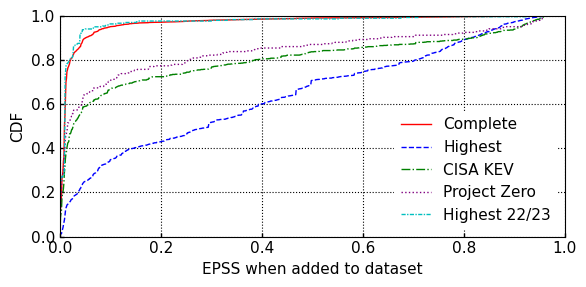

In [19]:
def retrieve_first_epss(df):
    return df.groupby('cve')['epss'].apply(lambda l: l.values[0])


data = [('Complete', retrieve_first_epss(df_dataset)),
        ('Highest', retrieve_first_epss(df_highest_epss)),
        ('CISA KEV', retrieve_first_epss(df_kev)),
        ('Project Zero', retrieve_first_epss(df_pz)),
        ('Highest 22/23', retrieve_first_epss(df_highest_epss_2223))]
fastplot.plot(data, None, mode='CDF_multi', xlim=(0.0, 1), grid=True, xlabel='EPSS when added to dataset', legend=True,
              figsize=(6, 3))

## Maximum EPSS

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

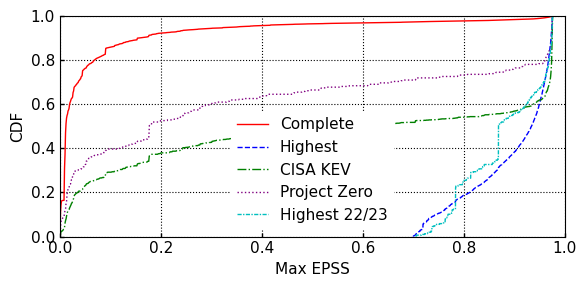

In [18]:
def retrieve_max_epss(df):
    return df.groupby('cve')['epss'].apply(lambda l: l.values.max())


data = [('Complete', retrieve_max_epss(df_dataset)),
        ('Highest', retrieve_max_epss(df_highest_epss)),
        ('CISA KEV', retrieve_max_epss(df_kev)),
        ('Project Zero', retrieve_max_epss(df_pz)),
        ('Highest 22/23', retrieve_max_epss(df_highest_epss_2223))]
fastplot.plot(data, None, mode='CDF_multi', xlim=(0.0, 1), grid=True, xlabel='Max EPSS', legend=True, figsize=(6, 3))

## Time for exceeding EPSS threshold

In [1]:
# Given the CVEs that reached T, plot the number of days they took
def compute_days_needed_to_reach_threshold(df):
    return df.groupby('cve')['epss'].apply(get_days_before_threshold).dropna()


def get_days_before_threshold(series):
    indices_above_threshold = [i for i, v in enumerate(series.values) if v > THRESHOLD]
    return indices_above_threshold[0] if indices_above_threshold else np.nan


data = [('Highest', compute_days_needed_to_reach_threshold(df_highest_epss)),
        ('CISA KEV > T', compute_days_needed_to_reach_threshold(df_kev)),
        ('Project Zero > T', compute_days_needed_to_reach_threshold(df_pz)),
        ('Highest 22/23', compute_days_needed_to_reach_threshold(df_highest_epss_2223))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#days taken to reach T', legend=True, figsize=(6, 3))

NameError: name 'df_highest_epss' is not defined

## Number of days exceeding EPSS threshold

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

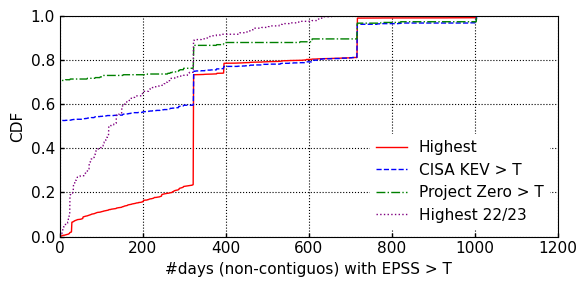

In [107]:
# Number of days each CVE has EPSS > T
def compute_days_above_T(df):
    return df.groupby('cve')['epss'].apply(lambda s: len([e for e in s.values if e > THRESHOLD]))


data = [('Highest', compute_days_above_T(df_highest_epss)),
        ('CISA KEV > T', compute_days_above_T(df_kev)),
        ('Project Zero > T', compute_days_above_T(df_pz)),
        ('Highest 22/23', compute_days_above_T(df_highest_epss_2223))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#days (non-contiguos) with EPSS > T', 
              legend=True, figsize=(6, 3))

## Maximum number of contiguous days exceeding EPSS threshold

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

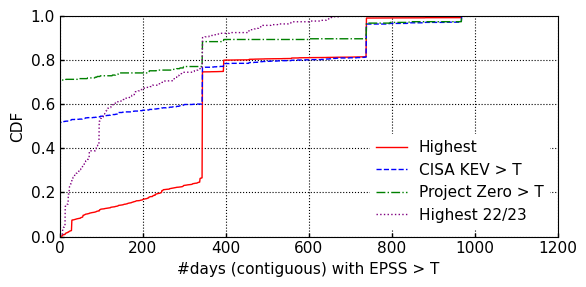

In [46]:
# Number of contiguous days in which CVEs has EPSS > T
def max_contiguous_days(dates):
    max_length = 1
    current_length = 1
    sorted_dates = sorted(dates)
    for i in range(1, len(sorted_dates)):
        if str(sorted_dates[i]) == '2022-07-15 00:00:00':
            current_length += 1
        elif sorted_dates[i] == sorted_dates[i - 1] + timedelta(days=1):
            current_length += 1
        else:
            current_length = 1
        max_length = max(max_length, current_length)
    return max_length


def compute_contiguos_days_above_T(df):
    epss_dates = df.groupby('cve')[['epss', 'date']].apply(lambda s: [d for e, d in zip(s['epss'].values, s['date'].values) if e > THRESHOLD])
    epss_dates_df = pd.DataFrame(epss_dates.items(), columns=['cve', 'dates'])
    epss_dates_df['dates'] = epss_dates_df['dates'].apply(lambda x: [pd.to_datetime(date) for date in x])
    return epss_dates_df['dates'].apply(max_contiguous_days)


data = [('Highest', compute_contiguos_days_above_T(df_highest_epss)),
        ('CISA KEV > T', compute_contiguos_days_above_T(df_kev)),
        ('Project Zero > T', compute_contiguos_days_above_T(df_pz)),
        ('Highest 22/23', compute_contiguos_days_above_T(df_highest_epss_2223))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#days (contiguous) with EPSS > T', 
              legend=True, figsize=(6, 3), xlim=(0, 1200))

## Percentage of days above the threshold wrt the life-time of the CVE

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

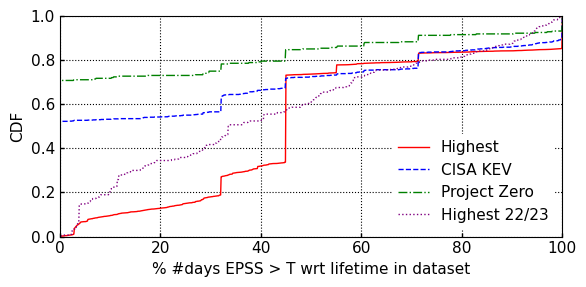

In [12]:
# Percentage of days above T wrt the life-time of the CVE
def compute_percentage_days_above_T_wrt_dataset_lifetime(df):
    return df.groupby('cve')['epss'].apply(lambda s: len([e for e in s.values if e > THRESHOLD]) / len(s.values) * 100)


data = [('Highest', compute_percentage_days_above_T_wrt_dataset_lifetime(df_highest_epss)),
        ('CISA KEV', compute_percentage_days_above_T_wrt_dataset_lifetime(df_kev)),
        ('Project Zero', compute_percentage_days_above_T_wrt_dataset_lifetime(df_pz)),
        ('Highest 22/23', compute_percentage_days_above_T_wrt_dataset_lifetime(df_highest_epss_2223))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='% #days EPSS > T wrt lifetime in dataset', 
              legend=True, figsize=(6, 3))

## Number of CVEs that exceed the threshold in 2022/2023 vs year of publication

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

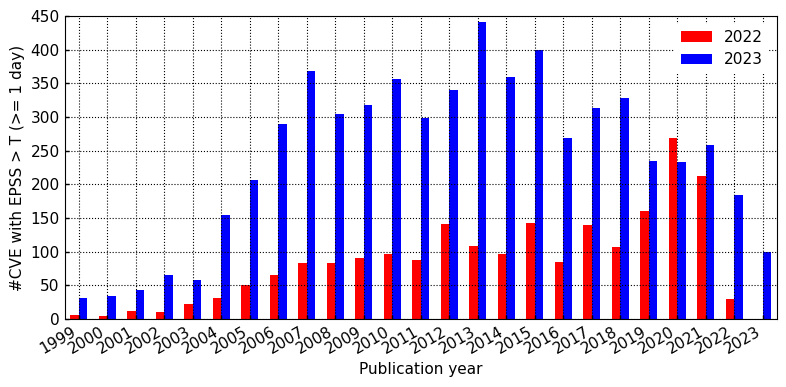

In [21]:
# Comparison of #CVE with EPSS > T for at least one day in 2022 and 2023 wrt year of publication
def subset_highest_epss_df_year(year):
    return df_highest_epss[df_highest_epss['date'].dt.year == year].groupby('cve')['epss'].apply(lambda l: l.values.max())


def count_entries_for_year(df, year):
    return sum(1 for i, cve in df.items() if str(year) in i.split('-')[1])


max_epss_2022 = subset_highest_epss_df_year(2022)
max_epss_2023 = subset_highest_epss_df_year(2023)
highest_epss_2022 = max_epss_2022[max_epss_2022 > THRESHOLD]
highest_epss_2023 = max_epss_2023[max_epss_2023 > THRESHOLD]
data = []
index = []
for year in range(1999, 2024):
    counter_2022 = count_entries_for_year(highest_epss_2022, year)
    counter_2023 = count_entries_for_year(highest_epss_2023, year)
    data.append([counter_2022, counter_2023])
    index.append(str(year))
df_plot = pd.DataFrame(data, index=index, columns=['2022', '2023'])
fastplot.plot(df_plot, None, mode='bars_multi', xlabel='Publication year',
              ylabel='#CVE with EPSS > T (>= 1 day)', xticks_rotate=30, figsize=(8, 4), legend=True, grid=True)

## Time series of CVE exceeding EPSS threshold published in 2022/2023

In [31]:
# Select data relative to a CVE from a given dataset
def get_cve_data(dataset, cve_id):
    return dataset[dataset['cve'] == cve_id][['epss', 'date', 'percentile']]


# Plot the timseries of a given CVE
def save_time_series_of_cve(cve_id, data, full_path):
    ts = pd.Series(data['epss'].values, index=data['date'].values)
    date_from = pd.Timestamp(str(data['date'].min()).split(' ')[0])
    date_to = pd.Timestamp(str(data['date'].max()).split(' ')[0])
    fastplot.plot(ts, full_path, mode='timeseries', ylabel=f"EPSS {cve_id}", xticks_rotate=30,
                  grid=True, ylim=(0.0, 1.0), xlim=(pd.Timestamp(date_from), pd.Timestamp(date_to)))
    
    
# Retrieve list of unique CVEs of 22/23 that reached T at least one time from a dataframe
def compute_highest_cve_list_2223(df):
    names = df.loc[(df['epss'] > THRESHOLD) & (df['cve'].str.contains('CVE-2022|CVE-2023'))]
    names = names.drop_duplicates(subset='cve')
    return names['cve'].tolist()

In [83]:
# Time series of highest CVE published in 22/23
highest_cve_pz = compute_highest_cve_list_2223(df_pz)
highest_cve_kev = compute_highest_cve_list_2223(df_kev)

path_folder_timeseries = './timeseries_highest_2223'
path_folder_timeseries_pz = f'{path_folder_timeseries}/pz'
path_folder_timeseries_kev = f'{path_folder_timeseries}/kev'
!rm -rf $path_folder_timeseries
os.mkdir(path_folder_timeseries)
os.mkdir(path_folder_timeseries_pz)
os.mkdir(path_folder_timeseries_kev)

for cve_id, data in df_highest_epss_2223.groupby('cve'):
    print(cve_id)
    if cve_id in highest_cve_pz:
        path = f"{path_folder_timeseries_pz}/{cve_id}"
    elif cve_id in highest_cve_kev:
        path = f"{path_folder_timeseries_kev}/{cve_id}"
    else:
        path = f"{path_folder_timeseries}/{cve_id}"
    save_time_series_of_cve(cve_id, data, path)
    clear_output(wait=True)
print(f"Check {path_folder_timeseries}")

Check ./timeseries_highest_2223


<Figure size 640x480 with 0 Axes>

## Introduction of EPSS v3.0

### Number of CVEs exceeding the EPSS threshold and average EPSS value day by day

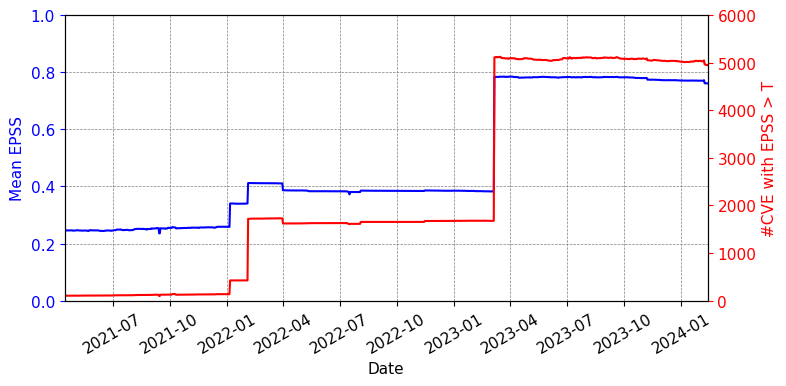

In [17]:
mean_epss = df_highest_epss.groupby('date')['epss'].mean()
cve_high_counter = df_highest_epss.groupby('date')['epss'].apply(lambda e: len([v for v in e.values if v > THRESHOLD]))

index = mean_epss.index
data1 = mean_epss.values
data2 = cve_high_counter.values

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(index, data1, color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean EPSS', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax2 = ax1.twinx()
ax2.plot(index, data2, color='r')
ax2.set_ylabel('#CVE with EPSS > T', color='r')
ax1.set_ylim(bottom=0, top=1.0)
ax2.set_ylim(bottom=0)
ax1.set_xlim(left=index.min(), right=index.max())
ax2.tick_params('y', colors='r')
plt.setp(ax1.get_xticklabels(), rotation=30)
fig.tight_layout()

### Scatter plot of the day before using the v3.0 model versus the day of release

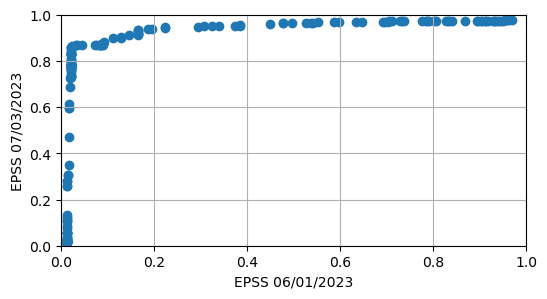

In [25]:
#
df_filtered = df_highest_epss_2223[(df_highest_epss_2223['date'] == '2023-03-06') | (df_highest_epss_2223['date'] == '2023-03-07')]
data1 = df_filtered[df_filtered['date'] == '2023-03-06']
intersection_cve = data1['cve'].unique()
data2 = df_filtered[(df_filtered['date'] == '2023-03-07') & (df_filtered['cve'].isin(intersection_cve))]
cve_list = list(data1['cve'])
epss_before_jump = list(data1['epss'].sort_values())
epss_on_jump = list(data2['epss'].sort_values())
plt.figure(figsize=(6, 3))
plt.scatter(epss_before_jump, epss_on_jump, marker='o')
plt.xlabel('EPSS 06/01/2023')
plt.ylabel('EPSS 07/03/2023')
# for i, cve in enumerate(cve_list):
    # plt.text(epss_before_jump[i], epss_on_jump[i], cve)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.grid(True)

### Spearman correlation

In [13]:
# Compute correlation between the day i and i - 1 for the dataset with the highest CVEs
dates = df_highest_epss['date'].unique()
correlations = []
df_prev = df_highest_epss[df_highest_epss['date'] == dates[0]]
for date in dates[1:]:
    df_curr = df_highest_epss[df_highest_epss['date'] == date]
    common_cve = np.intersect1d(df_prev['cve'], df_curr['cve'])
    df_prev_filtered = df_prev[df_prev['cve'].isin(common_cve)].sort_values(by='cve')
    df_curr_filtered = df_curr[df_curr['cve'].isin(common_cve)].sort_values(by='cve')
    correlation, _ = spearmanr(df_curr_filtered['epss'], df_prev_filtered['epss'])
    correlations.append((date, correlation))
    df_prev = df_curr

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

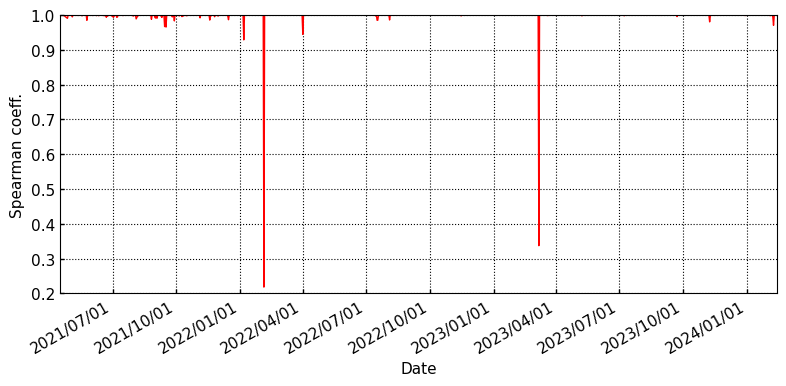

In [14]:
# Plot the time series
ts = pd.Series(dict(correlations))
date_from = pd.Timestamp(str(ts.index.min()).split(' ')[0])
date_to = pd.Timestamp(str(ts.index.max()).split(' ')[0])
fastplot.plot(ts, None, mode='timeseries', xlabel='Date', figsize=(8, 4), ylabel='Spearman coeff.', xticks_rotate=30, 
              grid=True, xlim=(pd.Timestamp(date_from), pd.Timestamp(date_to)))

In [24]:
# Dates corresponding to the peaks
for date, value in ts.items():
    if value < 0.9:
        print(date)

2022-02-04 00:00:00
2023-03-07 00:00:00


## Project Zero and CISA KEV

In [127]:
# Filter CVEs in PZ and KEV that reached T in 2014-2023 and in 2022/2023 and save the relative vendor, product and type
def retrieve_cve_by_epss_above_threshold(df):
    df = df.groupby('cve')['epss'].apply(lambda l: l.values.max())
    return df.groupby('cve').filter(lambda v: (v > THRESHOLD).any()).index.values


def filter_df_by_cve_list(df, cve_column_name, cve_list):
    return df[df[cve_column_name].isin(cve_list)]


df_pz_sheet = df_pz_sheet[['CVE', 'Vendor', 'Product', 'Type']].dropna()
highest_cve_pz_2223 = retrieve_cve_by_epss_above_threshold(df_pz[df_pz['cve'].str.contains('CVE-2022|CVE-2023')])
highest_cve_pz = list(filter(lambda e: e not in highest_cve_pz_2223, retrieve_cve_by_epss_above_threshold(df_pz)))
df_pz_sheet_highest = filter_df_by_cve_list(df_pz_sheet, 'CVE', highest_cve_pz)
df_pz_sheet_highest_2223 = filter_df_by_cve_list(df_pz_sheet, 'CVE', highest_cve_pz_2223)

df_kev_sheet = df_kev_sheet[['cveID', 'vendorProject', 'product', 'vulnerabilityName']]
highest_cve_kev_2223 = retrieve_cve_by_epss_above_threshold(df_kev[df_kev['cve'].str.contains('CVE-2022|CVE-2023')])
highest_cve_kev = list(filter(lambda e: e not in highest_cve_kev_2223, retrieve_cve_by_epss_above_threshold(df_kev)))
df_kev_sheet_highest = filter_df_by_cve_list(df_kev_sheet, 'cveID', highest_cve_kev)
df_kev_sheet_highest_2223 = filter_df_by_cve_list(df_kev_sheet, 'cveID', highest_cve_kev_2223)

### Distribution of CVEs that exceed the threshold vs vendor, product, type of vulnerability for Project Zero

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

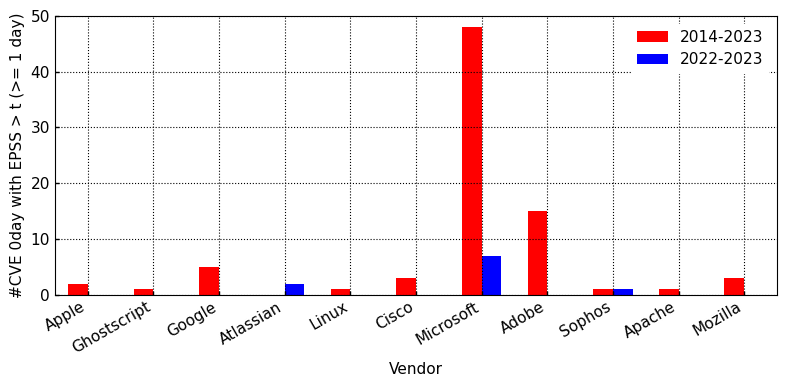

In [144]:
# Number of CVE of pz with EPSS > T per vendor
vendors_highest = list(df_pz_sheet_highest['Vendor'].unique())
vendors_2223 = list(df_pz_sheet_highest_2223['Vendor'].unique())
vendors = list(set(vendors_highest + vendors_2223))
data = pd.DataFrame([[len(df_pz_sheet_highest[df_pz_sheet_highest['Vendor'] == v]), len(df_pz_sheet_highest_2223[df_pz_sheet_highest_2223['Vendor'] == v])] for v in vendors],
                   index=[v for v in vendors],
                   columns=['2014-2023', '2022-2023'])
fastplot.plot(data, None, mode='bars_multi', xlabel='Vendor', ylabel='#CVE 0day with EPSS > T (>= 1 day)', 
              xticks_rotate=30, figsize=(8, 4), legend=True, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

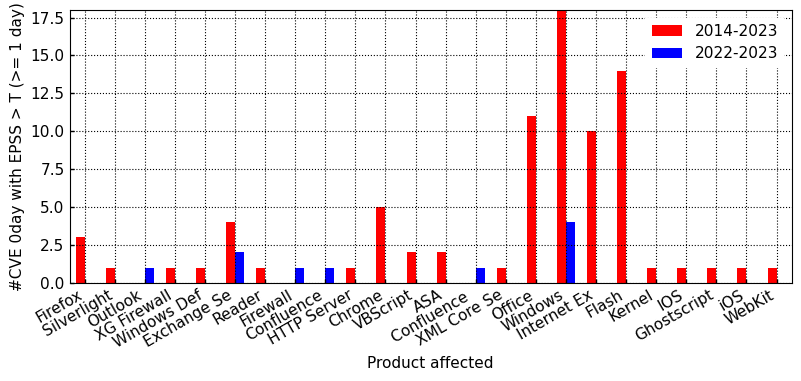

In [151]:
# Number of CVE of pz with EPSS > T per product
products_highest = list(df_pz_sheet_highest['Product'].unique())
products_2223 = list(df_pz_sheet_highest_2223['Product'].unique())
products = list(set(products_highest + products_2223))
data = pd.DataFrame([[len(df_pz_sheet_highest[df_pz_sheet_highest['Product'] == p]), len(df_pz_sheet_highest_2223[df_pz_sheet_highest_2223['Product'] == p])] for p in products],
                   index=[p[:11] for p in products],
                   columns=['2014-2023', '2022-2023'])
fastplot.plot(data, None, mode='bars_multi', xlabel='Product affected', ylabel='#CVE 0day with EPSS > T (>= 1 day)', 
              xticks_rotate=30, figsize=(8, 4), legend=True, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

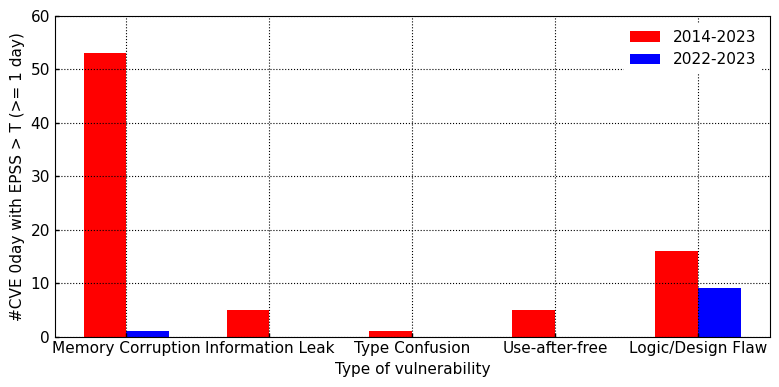

In [152]:
# Number of CVE of pz with EPSS > T per type of product
types_highest = list(df_pz_sheet_highest['Type'].unique())
types_2223 = list(df_pz_sheet_highest_2223['Type'].unique())
types = list(set(types_highest + types_2223))
data = pd.DataFrame([[len(df_pz_sheet_highest[df_pz_sheet_highest['Type'] == t]), len(df_pz_sheet_highest_2223[df_pz_sheet_highest_2223['Type'] == t])] for t in types],
                   index=[t for t in types],
                   columns=['2014-2023', '2022-2023'])
fastplot.plot(data, None, mode='bars_multi', xlabel='Type of vulnerability', ylabel='#CVE 0day with EPSS > T (>= 1 day)', 
              figsize=(8, 4), legend=True, grid=True)

### Distribution of CVEs that exceed the threshold vs vendor, product for CISA KEV

In [145]:
def group_values_with_less_frequency(tuples_list, keep_other=False):
    sum_of_ones = 0
    other_tuples = []
    for string, num in tuples_list:
        if num == 1:
            sum_of_ones += 1
        else:
            other_tuples.append((string, num))
    if sum_of_ones > 0 and keep_other == True:
        other_tuples.append(('Other', sum_of_ones))
    return other_tuples

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

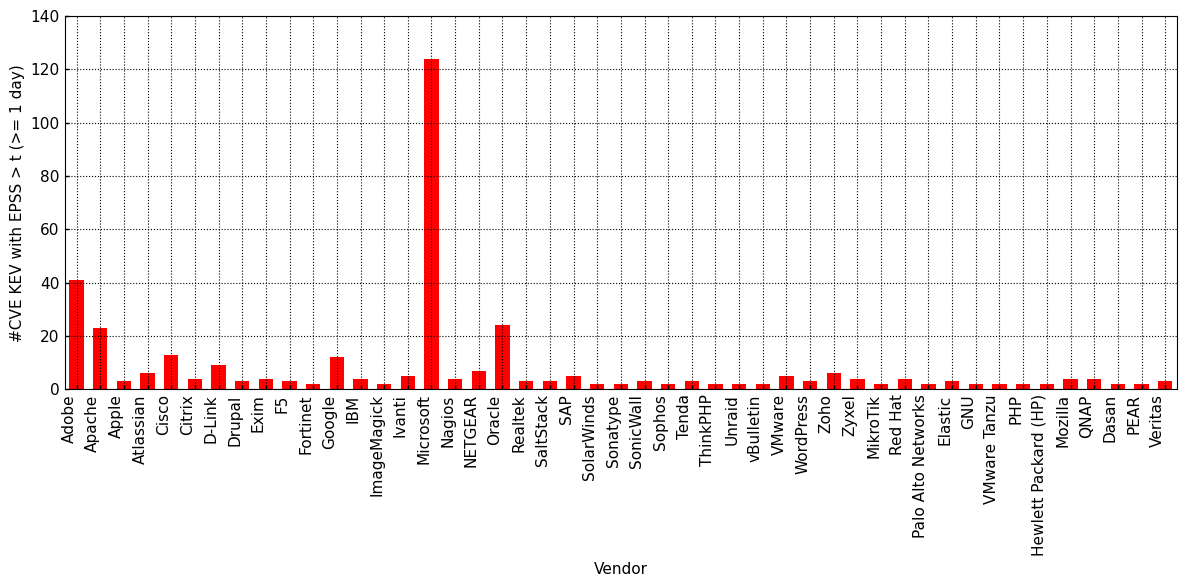

In [150]:
# Number of CVE of KEV with EPSS > T per vendor
vendors = list(df_kev_sheet_highest['vendorProject'].unique())
data = [(v, len(df_kev_sheet_highest[df_kev_sheet_highest['vendorProject'] == v])) for v in vendors]
data = group_values_with_less_frequency(data)
fastplot.plot(data, None, mode='bars', xlabel='Vendor', ylabel='#CVE KEV with EPSS > t (>= 1 day)', 
              xticks_rotate=90, figsize=(12, 6), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

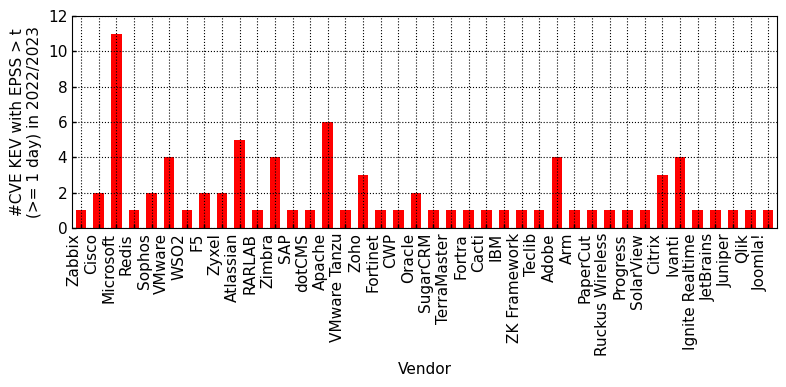

In [142]:
# Number of CVE of KEV 22/23 with EPSS > T per vendor
vendors_2223 = list(df_kev_sheet_highest_2223['vendorProject'].unique())
data = [(v, len(df_kev_sheet_highest_2223[df_kev_sheet_highest_2223['vendorProject'] == v])) for v in vendors_2223]
fastplot.plot(data, None, mode='bars', xlabel='Vendor', ylabel='#CVE KEV with EPSS > t\n(>= 1 day) in 2022/2023', 
              xticks_rotate=90, figsize=(8, 4), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

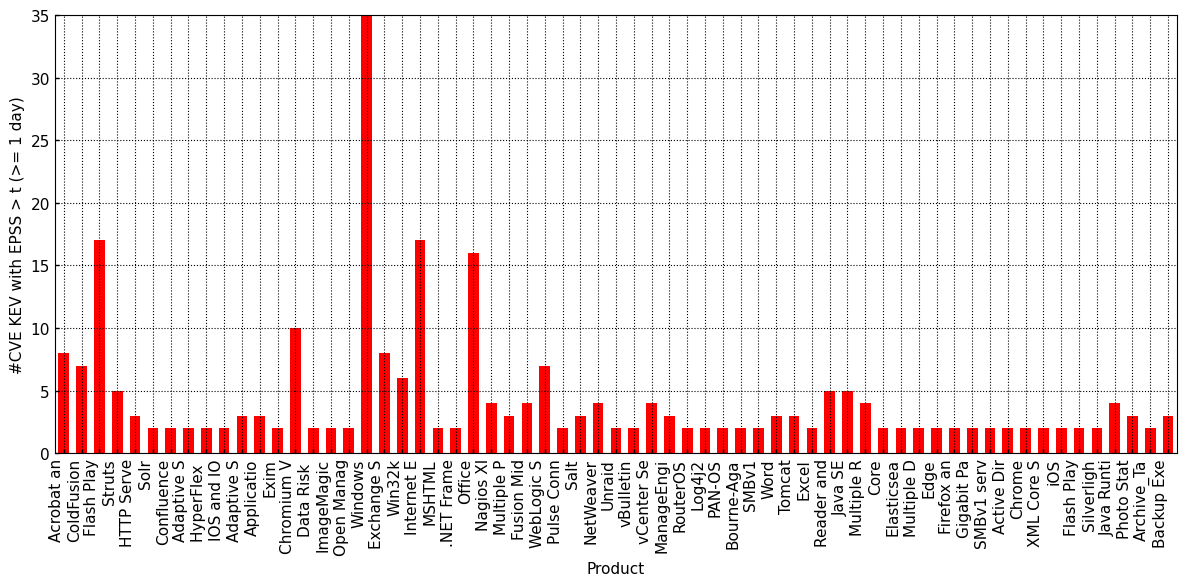

In [149]:
# Number of CVE of KEV with EPSS > T per product
products = list(df_kev_sheet_highest['product'].unique())
data = [(p[:10], len(df_kev_sheet_highest[df_kev_sheet_highest['product'] == p])) for p in products]
data = group_values_with_less_frequency(data)
fastplot.plot(data, None, mode='bars', xlabel='Product', ylabel='#CVE KEV with EPSS > t (>= 1 day)', 
              xticks_rotate=90, figsize=(12, 6), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

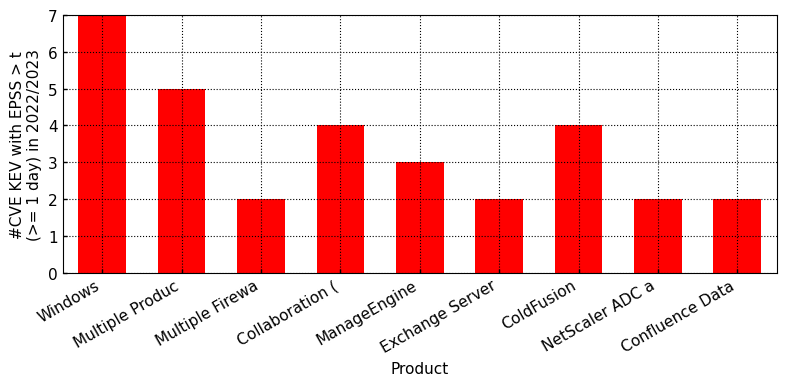

In [148]:
# Number of CVE of KEV 22/23 with EPSS > T per product
products_2223 = list(df_kev_sheet_highest_2223['product'].unique())
data = [(p[:15], len(df_kev_sheet_highest_2223[df_kev_sheet_highest_2223['product'] == p])) for p in products_2223]
data = group_values_with_less_frequency(data)
fastplot.plot(data, None, mode='bars', xlabel='Product', ylabel='#CVE KEV with EPSS > t\n(>= 1 day) in 2022/2023', 
              xticks_rotate=30, figsize=(8, 4), grid=True)

## hackthebox - Most popular CVEs from 2022

In [90]:
# Extract CVEs list from the website
data = requests.get('https://www.hackthebox.com/blog/most-popular-cybersecurity-vulnerabilities-and-exploits-from-2022')
soup = BeautifulSoup(data.text, 'html.parser')
table_cells = soup.find_all('td')
cve_hackthebox = []
for cell in table_cells:
    paragraphs = cell.find_all('p')
    for paragraph in paragraphs:
        links = paragraph.find_all('a')
        for link in links:
            cve_id = link.text
            if 'cve' in cve_id:
                cve_hackthebox.append(cve_id.upper())

In [91]:
# How many of those are inside the other dfs?
highest_cve_2223 = compute_highest_cve_list_2223(df_highest_epss_2223)
cve_hackthebox_highest_2223 = list(set(highest_cve_2223) & set(cve_hackthebox))
cve_hackthebox_pz_2223 = list(set(highest_cve_pz) & set(cve_hackthebox))
cve_hackthebox_kev_2223 = list(set(highest_cve_kev) & set(cve_hackthebox))
print(f"CVEs from hackthebox inside df_highest_epss_2223: {len(cve_hackthebox_highest_2223)}")
print(f"CVEs from hackthebox inside df_pz: {len(cve_hackthebox_pz_2223)}")
print(f"CVEs from hackthebox inside df_kev: {len(cve_hackthebox_kev_2223)}")

CVEs from hackthebox inside df_highest_epss_2223: 17
CVEs from hackthebox inside df_pz: 3
CVEs from hackthebox inside df_kev: 13


In [92]:
# Time-series
path_folder_timeseries_hackthebox = f'{path_folder_timeseries}/hackthebox'
!rm -rf $path_folder_timeseries_hackthebox
os.mkdir(path_folder_timeseries_hackthebox)
for cve_id in cve_hackthebox_highest_2223:
    if cve_id in highest_cve_pz:
        continue
    print(cve_id)
    to_remove_from_main_folder = f'{path_folder_timeseries}/{cve_id}.png'
    !rm $to_remove_from_main_folder
    data = get_cve_data(df_highest_epss_2223, cve_id)
    path = f"{path_folder_timeseries_hackthebox}/{cve_id}"
    save_time_series_of_cve(cve_id, data, path)
    clear_output(wait=True)
print(f"Check {path_folder_timeseries_hackthebox}")

Check ./timeseries_highest_2223/hackthebox


<Figure size 640x480 with 0 Axes>

## Number of CVEs that had an increase in EPSS of a certain value day by day

In [11]:
window = 1
step = 0.5
def test(cve_data):
    jumps = []
    for i in range(len(cve_data['date']) - window):
        eeps1 = cve_data["epss"].values[i]
        eeps2 = cve_data["epss"].values[i + window]
        if (eeps2 - eeps1) > step:
            day = cve_data["date"].values[i + window]
            jumps.append(day)
    return np.nan if jumps == [] else jumps


series_highest_epss_2223_with_step = df_highest_epss_2223.groupby('cve').apply(test).dropna()
dates = set()
for dates_list in series_highest_epss_2223_with_step.values:
    for date in dates_list:
        dates.add(date)
        
counter_per_date = {}

for date in dates:
    for e in series_highest_epss_2223_with_step.values:
        if date in e:
            if date in counter_per_date:
                counter_per_date[date] = counter_per_date[date] + 1
            else: 
                counter_per_date[date] = 1
for k, v in counter_per_date.items():
    print(f"{str(k).split('T')[0]} -> {v}")

2022-12-06 -> 1
2023-03-20 -> 3
2023-03-07 -> 111
2023-03-01 -> 1
2022-05-12 -> 1
2023-03-31 -> 1
2022-05-04 -> 1
2023-03-18 -> 1
2022-11-02 -> 1
2022-06-15 -> 1
2023-04-21 -> 2
2022-05-24 -> 1
2023-06-20 -> 1
2023-08-31 -> 2
2023-04-01 -> 1
2023-01-27 -> 1
2023-08-04 -> 1
2023-08-07 -> 2
2023-12-05 -> 1
2023-05-02 -> 2
2023-07-13 -> 6
2023-08-30 -> 11
2023-06-19 -> 4
2023-02-03 -> 1
2023-10-17 -> 1
2023-11-10 -> 1
2022-09-20 -> 1
2023-05-10 -> 1
2023-05-18 -> 2
2022-10-13 -> 1
2023-11-17 -> 1
2022-10-21 -> 2
2023-11-09 -> 3
2023-11-01 -> 2
2023-03-22 -> 1
2023-08-13 -> 1
2023-06-10 -> 1
2023-09-30 -> 1
2023-08-05 -> 2
2023-12-14 -> 1
2023-09-29 -> 1
2023-08-22 -> 1
2023-07-27 -> 11
2023-05-16 -> 7
2023-07-11 -> 3
2023-03-29 -> 1
2023-02-01 -> 1
2023-10-31 -> 3
2023-09-13 -> 1
2023-06-17 -> 1
2023-05-08 -> 5
2023-05-19 -> 1
2023-12-23 -> 1
2023-10-27 -> 1
2024-01-14 -> 5
2023-05-03 -> 2
2023-07-21 -> 1
2023-06-08 -> 1
2023-08-19 -> 1
2023-10-22 -> 4
2023-06-24 -> 1
2023-07-10 -> 1
2023